##RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to quantitatively rank and group customers based on their purchase history to identify the best customers and understand their behavior.

The RFM model helps in segmenting customers into various categories, typically for targeted marketing campaigns. It considers the following three factors:

*   List Recency (R): How recently a customer has made a purchase. Customers who have purchased recently are more likely to respond to new offers.
*   Frequency (F): How often a customer makes a purchase. A higher frequency indicates a loyal customer.
*   Monetary Value (M): How much money a customer spends on purchases. Customers who spend more are often considered more valuable.








In [ ]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [ ]:
#Import Data
df = pd.read_csv("/content/sample_data/UK Retail Data.csv", index_col=0)
df.head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,UnitPrice,Total_Purchase,Country
0,536365,2010-12-01,17850.0,6,2.55,15.30,United Kingdom
1,536365,2010-12-01,17850.0,6,3.39,20.34,United Kingdom
2,536365,2010-12-01,17850.0,8,2.75,22.00,United Kingdom
3,536365,2010-12-01,17850.0,2,7.65,15.30,United Kingdom
4,536365,2010-12-01,17850.0,6,4.25,25.50,United Kingdom


In [ ]:
#Check the Last order date
last_order_date = df['InvoiceDate'].max()
print(last_order_date)

2011-12-09


###Online Retail Data contains transactions from 01/12/2010 and 09/12/2011.

In [ ]:
#Check the number of columns and rows in the dataset
df.shape

(220338, 7)

In [ ]:
#Check for missing values in the dataset
df.isnull().sum(axis=0)

InvoiceNo         0
InvoiceDate       0
CustomerID        0
Quantity          0
UnitPrice         0
Total_Purchase    0
Country           0
dtype: int64

In [ ]:
#Validate if there are any negative values in Quantity column
df.Quantity.min()

1

In [ ]:
#Set Latest date 2011-12-10 as last invoice date was 2011-12-09.
#This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

## Traditional RFM Modelling: To predict customer value

##RFM Calculation Using Formula
To calculate RFM scores manually, you can follow these general steps:

*   Recency (R): Calculate the number of days since the last purchase for each customer. The most recent purchases are ranked higher.
*   Frequency (F): Count the number of purchases for each customer over a certain period. More frequent purchasers get a higher rank.
*   Monetary (M): Sum up the total money spent by each customer over a certain period. Customers who spent the most are ranked higher.

After calculating these values, we can assign a score (typically from 1 to 5) to each R, F, and M component for each customer and rank customers based on quintiles for each factor.

In [ ]:
#Create RFM Modelling scores for each customer
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
RFMScores = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days,
                                          'InvoiceNo': lambda x: len(x),
                                          'Total_Purchase': lambda x: x.sum()})


In [ ]:
#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

In [ ]:
#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Total_Purchase': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12747.0,3,89,3820.29
2,12748.0,1,2787,25744.01
3,12749.0,4,118,2616.57
4,12820.0,4,38,623.16


In [ ]:
#Descriptive Statistics (Recency)
RFMScores.Recency.describe()

count    3921.000000
mean       92.722265
std        99.528532
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: Recency, dtype: float64

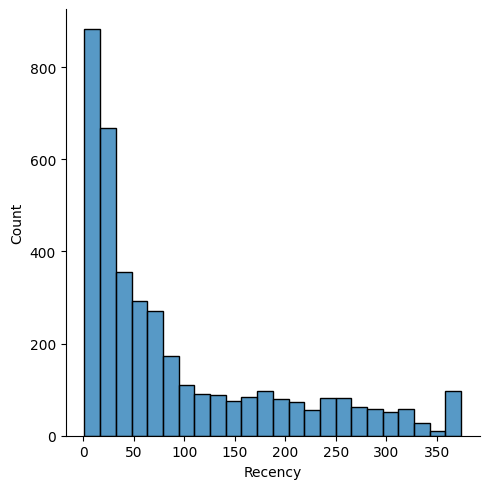

In [ ]:
#Recency distribution plot
x = RFMScores['Recency']

ax = sns.displot(x)

In [ ]:
#Descriptive Statistics (Frequency)
RFMScores.Frequency.describe()

count    3921.000000
mean       56.194338
std       120.001371
min         1.000000
25%        12.000000
50%        27.000000
75%        63.000000
max      4258.000000
Name: Frequency, dtype: float64

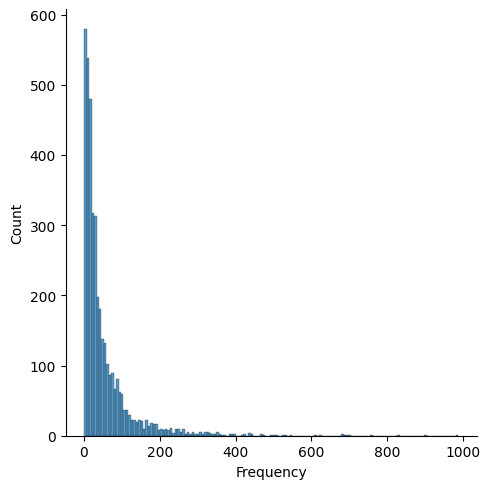

In [ ]:
#Frequency distribution plot, taking observations which have frequency less than 1000
x = RFMScores.query('Frequency < 1000')['Frequency']

ax = sns.displot(x)

In [ ]:
#Descriptive Statistics (Monetary)
RFMScores.Monetary.describe()

count      3921.000000
mean       1401.319537
std        6024.430165
min           0.000000
25%         213.960000
50%         479.620000
75%        1121.500000
max      173369.020000
Name: Monetary, dtype: float64

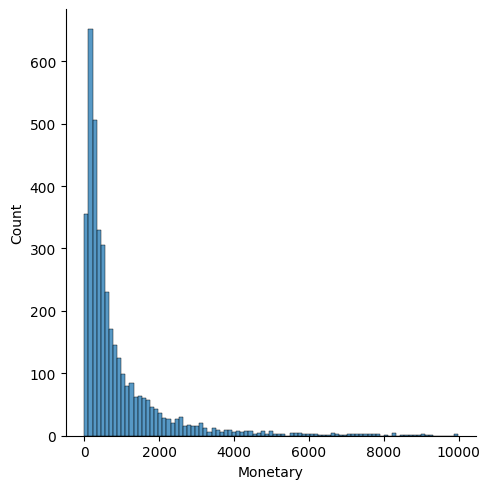

In [ ]:
#Monateray distribution plot, taking observations which have monetary value less than 10000
x = RFMScores.query('Monetary < 10000')['Monetary']

ax = sns.displot(x)

In [ ]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
quantiles

{'Recency': {0.25: 18.0, 0.5: 51.0, 0.75: 143.0},
 'Frequency': {0.25: 12.0, 0.5: 27.0, 0.75: 63.0},
 'Monetary': {0.25: 213.96000000000004, 0.5: 479.62, 0.75: 1121.5}}

In [ ]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [ ]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,4,4,1
12747.0,3,89,3820.29,1,1,1
12748.0,1,2787,25744.01,1,1,1
12749.0,4,118,2616.57,1,1,1
12820.0,4,38,623.16,1,2,2


In [ ]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,326,1,77183.60,4,4,1,441,9
12747.0,3,89,3820.29,1,1,1,111,3
12748.0,1,2787,25744.01,1,1,1,111,3
12749.0,4,118,2616.57,1,1,1,111,3
12820.0,4,38,623.16,1,2,2,122,5


In [ ]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,326,1,77183.60,4,4,1,441,9,Silver
1,12747.0,3,89,3820.29,1,1,1,111,3,Platinum
2,12748.0,1,2787,25744.01,1,1,1,111,3,Platinum
3,12749.0,4,118,2616.57,1,1,1,111,3,Platinum
4,12820.0,4,38,623.16,1,2,2,122,5,Platinum


In [ ]:
#Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,1,308,173369.02,1,1,1,111,3,Platinum
1,17450.0,9,250,168503.41,1,1,1,111,3,Platinum
2,17511.0,3,613,61826.50,1,1,1,111,3,Platinum
3,17949.0,2,68,57831.28,1,1,1,111,3,Platinum
4,16684.0,5,216,54425.08,1,1,1,111,3,Platinum
5,15061.0,4,350,48969.70,1,1,1,111,3,Platinum
6,14088.0,11,499,44785.87,1,1,1,111,3,Platinum
7,13694.0,4,389,44045.16,1,1,1,111,3,Platinum
8,15311.0,1,1718,43569.81,1,1,1,111,3,Platinum
9,13089.0,3,1073,42311.45,1,1,1,111,3,Platinum
